In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import random

In [61]:
def get_data():
    print("Fetching Data...")
    train = pd.read_csv("./data/pa3_train.csv")
    val = pd.read_csv("./data/pa3_val.csv")
    test = pd.read_csv("./data/pa3_test.csv")
    return train,val,test

def plot_accuracy(train_accuracy,val_accuracy,depth,x_label,title):
    plt.figure(figsize=(10,7))
    plt.plot(depth, train_accuracy, marker = 'o', label = "Training Accuracy", color = 'red')
    plt.plot(depth, val_accuracy, marker = 'o', label = "Validation Accuracy", color = 'blue')
    plt.legend(loc = 'best')
    plt.title(title, fontsize = 20)
    plt.xlabel(x_label, fontsize = 15)
    plt.ylabel("Accuracy\n" + "Max Training = " + str(max(train_accuracy)) +
              "\nMax Validation = " + str(max(val_accuracy)), fontsize = 15)
    plt.savefig("./plot/"+title+".png")
    plt.show()

In [62]:
#train_df.iloc[:,1]
#train.loc[0:4,:]

# Helper Functions

In [75]:
#Check if node is pure
def check_pure(data):
    label = data[:, -2]
    #print(data)
    unique_labels = np.unique(label)

    if len(unique_labels) == 1:
        return True
    else:
        return False
    
#Classify data based on majority class labels    
def classify(data):
    """
    Returns a class label
    """
    """
    label = data[:, -2]

    #1st array: unique values | 2nd array: count of corresponding unique values
    unique_classes, count_unique_classes = np.unique(label, return_counts=True)


    #get index of label with highest count
    index = count_unique_classes.argmax()
    classification  = unique_classes[index]
    """
    label = data[:,-2]
    weights = data[:,-1]
    
    zeros_index = label == 0
    ones_index = label == 1
    
    zeros_weight = sum(weights[zeros_index])
    ones_weight = sum(weights[ones_index])
    
    if zeros_weight > ones_weight:
        classification = 0
    else:
        classification = 1
    
    return classification

def get_potential_split(data):
    """
    Returns a disctionary:
        * KEY : feature_name
        * VALUE: unique_values
    """
    
    #potential_splits = {cap-shape:[0,1],population:[0,1]....}
    
    potential_splits = {}
    #Get number of columns
    n_columns = data.shape[1]
    for column_index in range(n_columns - 2):
        potential_splits[column_index] = []
        values = data[:,column_index]
        unique_values = np.unique(values)

        if len(unique_values) > 1:
            potential_splits[column_index] = unique_values
    
    #print(potential_splits)
    return potential_splits

#Split data based of feature value
def split_data(data, split_column, split_value = 0):
    
    feature_values = data[:,split_column]
    data_below = data[feature_values == split_value]
    data_above = data[feature_values != split_value]
        
    
    return data_below, data_above


# Gini Index
def calculate_gini_index(data):

    """
    # Unweighted Gini Index
    label_column = data[:,-2]
    counts = np.unique(label_column, return_counts=True)[1]
    probabilities = counts/sum(counts)
    probabilities = probabilities**2
    gini_index = 1 - sum(probabilities)
    """
    probabilities = np.zeros(2)
    
    
    label = data[:,-2]
    weights = data[:,-1]
    weights = weights/sum(weights)
    
    #print("LABEL", label, "WEIGHTS", weights)
    zeros_index = label == 0
    ones_index = label == 1
    
    zeros_weight = sum(weights[zeros_index])
    ones_weight = sum(weights[ones_index])
    
    #print(zeros_weight,ones_weight)
    
    probabilities[0] = zeros_weight
    probabilities[1] = ones_weight
    probabilities = probabilities**2
    gini_index = 1 - sum(probabilities)
    
    
    return gini_index

def calculate_overall_gini_index(data_below, data_above):


    n = len(data_above) + len(data_below)
    p_data_above = len(data_above)/n
    p_data_below = len(data_below)/n
    
    overall_gini_index = ((p_data_above * calculate_gini_index(data_above)) 
                            + (p_data_below * calculate_gini_index(data_below)))
    
    return overall_gini_index

def find_best_split(data, potential_splits):
    
    #In case there is no potential splits for small m values
    best_split_column = 7777
    
    benifit_of_split = 0
    for column_index in potential_splits:
        #print(column_index,potential_splits[column_index][0])
        if len(potential_splits[column_index]) > 0 :
            #print(potential_splits[column_index][0])
            value = 0
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_child_gini_index = calculate_overall_gini_index(data_below, data_above)
            current_overall_parent_gini_index = calculate_gini_index(data)
            current_benefit = current_overall_parent_gini_index - current_overall_child_gini_index

            #print(current_benefit, benifit_of_split)
            if current_benefit >= benifit_of_split:
                benifit_of_split = current_benefit
                best_split_column = column_index
    
    return best_split_column



# Classify using Tree

In [76]:
def classify_example(example, tree):
    
    #print(tree)
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    if str(example[feature_name]) == value:
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    #Base case
    if not isinstance(answer,dict):
        return answer

    #Recursive case
    else:
        residual_tree = answer
        return classify_example(example,residual_tree)
    
def calculate_accuracy(df, tree):
        
    prediction = df.apply(classify_example, args=(tree,), axis=1)
    accuracy_bool = prediction == df["class"].values
    
    return np.mean(accuracy_bool)

## Tree Algorithm

In [77]:
def decision_tree_algo(df, max_depth, D, current_depth = 0):
    
    
    #Set data to 2-D array in the first iteration
    if current_depth == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        df["weights"] = D
        data = df.values
    else:
        data = df
    
    #Base case - When node is pure
    if(check_pure(data) or current_depth>= max_depth):
        classification = classify(data)
        return classification
        
    #Recursive part - when node is not pure
    else:
        current_depth += 1
        
        #helper functions
        potential_splits = get_potential_split(data)
        split_column = find_best_split(data, potential_splits)
        
        #If no split exists, then classify data:
        if split_column == 7777:
            classification = classify(data)
            return classification
        
        data_below, data_above = split_data(data, split_column=split_column, split_value=0)
        
        #instanciate subtree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} = 0".format(feature_name)
        sub_tree = {question: []}
            
        
        #find answer(Recursion)
        yes_answer = decision_tree_algo(data_below, max_depth, D, current_depth)
        no_answer = decision_tree_algo(data_above, max_depth, D, current_depth)

        """
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
        """
        sub_tree[question].append(yes_answer) 
        sub_tree[question].append(no_answer)

        return sub_tree
    

In [66]:
train_df,val_df,test_df = get_data()
data = train_df.values

Fetching Data...


# Part 1
*Grow Trees with depth [1,2,3,4,5,6,7,8]*

In [67]:
def get_best_tree(max_depth):
    
    acc = 0
    best_tree = {}
    depth = list(range(1,max_depth+1))
    train_accuracy = []
    val_accuracy = []
    D = np.array([1/len(train_df)]*len(train_df))
    for i in depth:
        print(f"Running Depth = {i}")
        tree = decision_tree_algo(train_df, max_depth=i, D=D)
        train_df.drop(columns="weights", inplace=True)
        train_accuracy.append(calculate_accuracy(train_df,tree))
        val_accuracy.append(calculate_accuracy(val_df,tree))
        
        if val_accuracy[i-1] > acc:
            best_tree = tree
            best_depth = i
            acc = val_accuracy[i-1]
    
    plot_accuracy(train_accuracy,val_accuracy,depth,x_label="Depth",title="Accuracy Vs Depth")
    
    print("Train_Accuracy")
    print(train_accuracy)
    print("Validation_Accuracy")
    print(val_accuracy)
    
    return best_tree, best_depth

### 1a)

In [68]:
print("------------------------------------1b---------------------------------------")
print("Tree with depth 2")
D = np.array([1/len(train_df)]*len(train_df))
tree = decision_tree_algo(train_df,max_depth=2,D=D)
print(tree)

------------------------------------1b---------------------------------------
Tree with depth 2
{'odor_n = 0': [{'stalk-root_c = 0': [1, 0]}, {'spore-print-color_r = 0': [0, 1]}]}


### 1b)

------------------------------------1c---------------------------------------
Running Depth = 1
Running Depth = 2
Running Depth = 3
Running Depth = 4
Running Depth = 5
Running Depth = 6
Running Depth = 7
Running Depth = 8


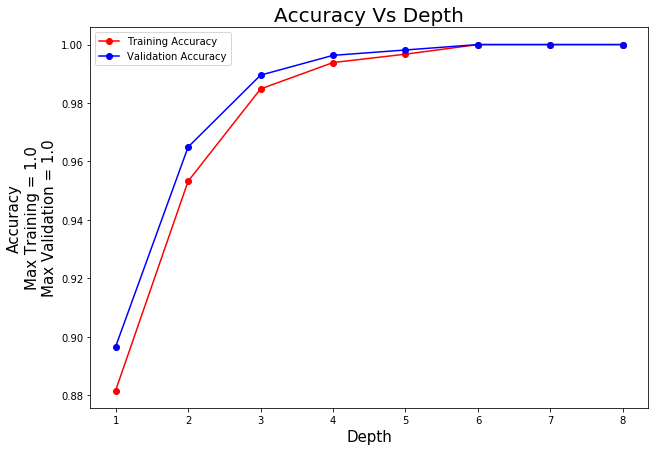

Train_Accuracy
[0.8816167418957734, 0.9532211735740664, 0.9848173984407058, 0.9938448912597456, 0.9967172753385309, 1.0, 1.0, 1.0]
Validation_Accuracy
[0.8966153846153846, 0.9649230769230769, 0.9895384615384616, 0.9963076923076923, 0.9981538461538462, 1.0, 1.0, 1.0]


In [69]:
print("------------------------------------1c---------------------------------------")
best_tree, best_depth = get_best_tree(8)
#best_tree

# PART 2

# Random Forest

In [70]:
def random_forest(df, n, m, d):
    """
    n: #trees in the forest
    m: #features for a tree
    d: max depth of the tree in the forest
    """
    forest = []
    tree_counter = 0
    
    #Get #rows and #columns
    df_rows = df.shape[0]
    df_columns = df.shape[1]
    
    D = np.array([1/len(train_df)]*len(train_df))
    
    #random.seed(534)
    while tree_counter < n:
        
        #sampling data points with replacement
        df_sample_ids = random.choices(list(range(df_rows)), k=df_rows)

        #sampling features without replacements
        feature_sample_ids = random.sample(list(range(df_columns - 1)), m)
        ##Adding "class" back to the feature subset
        feature_sample_ids.append(df_columns - 1)

        #New sample df [sampled datapoints and features]
        sample_df = df.iloc[df_sample_ids,feature_sample_ids]

        tree = decision_tree_algo(sample_df, max_depth=d, D=D)
        sample_df.drop(columns="weights", inplace=True)
        
        #check if tree is valid
        if isinstance(tree, dict):
            forest.append(tree)
            tree_counter += 1
            
    
    return forest

def forest_accuracy(df, forest):
    
    prediction = pd.DataFrame()
    for i in range(len(forest)):
        
        tree = forest[i]
        #Prediction using a tree in the forest
        prediction[i] = (df.apply(classify_example, args=(tree,), axis=1))

    #Calculate number of zeros voted amongst all trees        
    no_columns = prediction.shape[1]
    number_of_zeros = no_columns - prediction.apply(sum, axis=1)
    
    #Check majority vote: Predict 1 if Pr(0) < 0.5 or Number of zeros is less than half the total population
    final_prediction = (number_of_zeros < (no_columns/2)).astype(int)
    accuracy_bool = final_prediction == df["class"].values
    
    return np.mean(accuracy_bool)
    #return prediction, number_of_zeros, final_prediction

In [71]:
#my_forest = random_forest(train_df, n=10, m=10, d=3)

In [72]:
#forest_accuracy(val_df, my_forest)

### 2b)

In [78]:
def part_2b(no_of_trees):
    
    acc = 0
    train_accuracy = []
    val_accuracy = []
    
    for i in range(len(no_of_trees)):
        print(f"Running n = {no_of_trees[i]}")
        n = no_of_trees[i]
        my_forest = random_forest(train_df, n=n, m=5, d=2)
        train_accuracy.append(forest_accuracy(train_df, my_forest))
        val_accuracy.append(forest_accuracy(val_df, my_forest))
        
        if val_accuracy[i] > acc:
            best_n = n
            acc = val_accuracy[i]
    
    #x_axis = list(range(1,len(no_of_trees) + 1))
    plot_accuracy(train_accuracy,val_accuracy,no_of_trees,x_label="#Trees", title="2b")
    
    print("Train_Accuracy")
    print(train_accuracy)
    print("Validation_Accuracy")
    print(val_accuracy)
    
    return best_n

In [ ]:
print("------------------------------------2b---------------------------------------")
n = [1,2,5,10,25]
part_2b(n)

------------------------------------2b---------------------------------------
Running n = 1
Running n = 2
Running n = 5
Running n = 10


### 2d)

In [13]:
def part_2d(no_of_features):
    
    acc = 0
    train_accuracy = []
    val_accuracy = []
    
    for i in range(len(no_of_features)):
        print(f"Running m = {no_of_features[i]}")
        m = no_of_features[i]
        my_forest = random_forest(train_df, n=15, m=m, d=2)
        train_accuracy.append(forest_accuracy(train_df, my_forest))
        val_accuracy.append(forest_accuracy(val_df, my_forest))
        
        if val_accuracy[i] > acc:
            best_m = m
            acc = val_accuracy[i]
    
    #x_axis = list(range(1,len(no_of_trees) + 1))
    plot_accuracy(train_accuracy,val_accuracy,no_of_features,x_label="#Features", title="2d")
    
    print("Train_Accurac")
    print(train_accuracy)
    print("Validation_Accuracy")
    print(val_accuracy)
    
    
    return best_m

------------------------------------2d---------------------------------------
Running m = 1
Running m = 2
Running m = 5
Running m = 10
Running m = 25


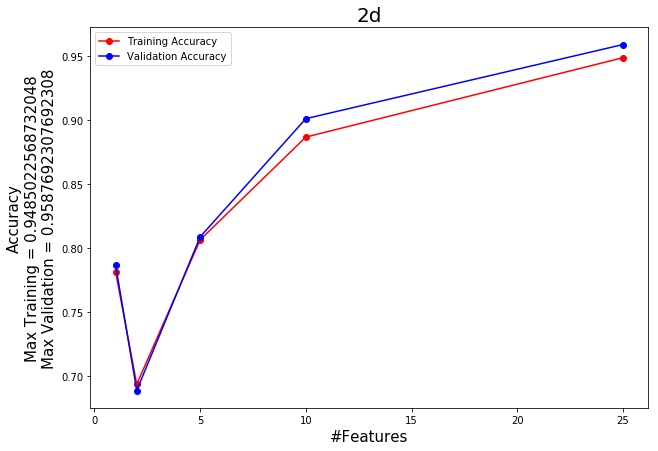

Train_Accurac
[0.7812884694296266, 0.6934755847353303, 0.8063192449733279, 0.886540828887977, 0.9485022568732048]
Validation_Accuracy
[0.7864615384615384, 0.6886153846153846, 0.8086153846153846, 0.9009230769230769, 0.9587692307692308]


25

In [32]:
print("------------------------------------2d---------------------------------------")
m = [1,2,5,10,25]
part_2d(m)

In [14]:
def part2e():
    acc = 0
    train_accuracy = []
    val_accuracy = []
    run = list(range(1,11))
    
    for i in range(0,10):
        print(f"Running Run no = {i+1}")
        my_forest = random_forest(train_df, n=15, m=25, d=2)
        train_accuracy.append(forest_accuracy(train_df, my_forest))
        val_accuracy.append(forest_accuracy(val_df, my_forest))
        
        if val_accuracy[i] > acc:
            best_acc = val_accuracy[i]
            acc = val_accuracy[i]
    
    #x_axis = list(range(1,len(no_of_trees) + 1))
    plot_accuracy(train_accuracy,val_accuracy,run,x_label="iteration", title="2e [n = 15 & m = 25]")
    
    print("Train_Accuracy")
    print(train_accuracy)
    print("Validation_Accuracy")
    print(val_accuracy)
    
    return best_acc

------------------------------------2e---------------------------------------
Running Run no = 1
Running Run no = 2
Running Run no = 3
Running Run no = 4
Running Run no = 5
Running Run no = 6
Running Run no = 7
Running Run no = 8
Running Run no = 9
Running Run no = 10


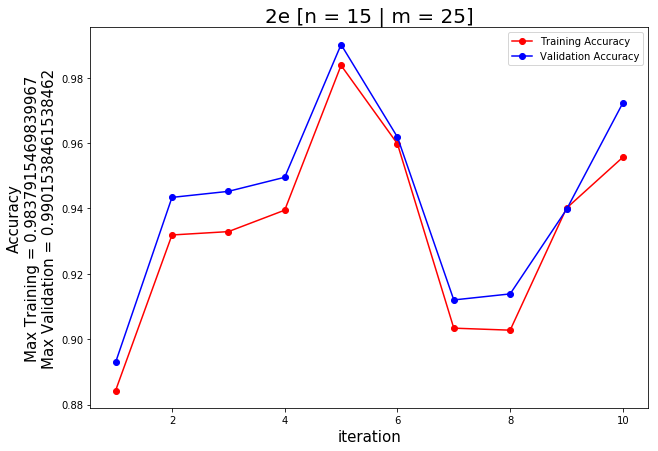

Train_Accuracy
[0.884283955683217, 0.9318834632745179, 0.932909314731227, 0.939474764054165, 0.9837915469839967, 0.9597866228970046, 0.9033647927780057, 0.9027492819039803, 0.9400902749281904, 0.9556832170701682]
Validation_Accuracy
[0.8929230769230769, 0.9433846153846154, 0.9452307692307692, 0.9495384615384616, 0.9901538461538462, 0.9618461538461538, 0.912, 0.9138461538461539, 0.9396923076923077, 0.9723076923076923]


0.9901538461538462

In [33]:
print("------------------------------------2e---------------------------------------")

part2e()

# PART 3

In [59]:
def ada_boost(base_learners,depth=1):
    
    #acc = 0
    tree_counter = 0
    best_tree = {}
    L = list(range(1,base_learners+1))
    D = np.array([1/len(train_df)]*len(train_df))
    
    train_accuracy = []
    val_accuracy = []
    a = []
    forest = []
    
    while tree_counter < base_learners:
        #print(sum(D))
        #print(f"base learner no:  {tree_counter + 1}")
        tree = decision_tree_algo(train_df, max_depth=depth, D=D)

        
        if not isinstance(tree, dict):
            D = train_df["weights"] + 0.025
            train_df["weights"] = D/sum(D)
            D = train_df["weights"]
            print("XX")
        #print(tree)
        
    
        if isinstance(tree, dict):
            
            tree_counter += 1

            prediction = train_df.drop(columns="weights").apply(classify_example, args=(tree,), axis=1)
            D = train_df["weights"]
            #weighted error
            w_error = sum(D[prediction != train_df["class"]])
            #print(w_error)
            #print(np.unique(D,return_counts=True))
            alpha = (1/2)*np.log2((1-w_error)/w_error)
            a.append(alpha)
            forest.append(tree)

            #update weights
            train_df.loc[prediction != train_df["class"],"weights"] = train_df.loc[prediction != train_df["class"],"weights"] * np.exp(alpha)
            train_df.loc[prediction == train_df["class"],"weights"] = train_df.loc[prediction == train_df["class"],"weights"] * np.exp(-alpha)

            #normalize weights
            D = train_df["weights"]
            train_df["weights"] = D/sum(D)
            D = train_df["weights"]
    
    train_df.drop(columns="weights", inplace=True)
    
    return forest, a

In [53]:
def boost_accuracy(df, alpha, forest):
    
    prediction = pd.DataFrame()
    for i in range(len(forest)):
        
        tree = forest[i]
        #Prediction using a tree in the forest
        prediction[i] = (df.apply(classify_example, args=(tree,), axis=1))

    #Calculate number of zeros voted amongst all trees        
    no_columns = prediction.shape[1]
    prediction[prediction==0] = -1
    prediction["aggregated_weights"] = np.dot(prediction,alpha)
    final_prediction = (prediction["aggregated_weights"] >= 0).astype(int)
    #prediction["prediction"] = final_prediction
    
    accuracy_bool = final_prediction == df["class"].values
    
    return np.mean(accuracy_bool)

In [55]:
fores, alph = ada_boost(15,1)

NameError: name 'f' is not defined

In [51]:
fores

[{'odor_n = 0': [1, 0]},
 {'stalk-surface-above-ring_k = 0': [0, 1]},
 {'stalk-root_c = 0': [1, 0]},
 {'odor_f = 0': [0, 1]},
 {'population_y = 0': [1, 0]},
 {'odor_f = 0': [0, 1]},
 {'odor_f = 0': [1, 1]},
 {'odor_f = 0': [0, 1]},
 {'odor_f = 0': [1, 1]},
 {'odor_f = 0': [0, 1]},
 {'odor_f = 0': [1, 1]},
 {'odor_f = 0': [0, 1]},
 {'odor_f = 0': [1, 1]},
 {'odor_f = 0': [0, 1]},
 {'odor_f = 0': [1, 1]}]

In [57]:
def part_3c(no_of_learners):
    
    acc = 0
    train_accuracy = []
    val_accuracy = []
    #train_df.drop(columns="veil-type_p", inplace = True)
    for i in range(len(no_of_learners)):
        print(f"Running no of learners = {no_of_learners[i]}")
        m = no_of_learners[i]
        my_forest, alpha = ada_boost(m, depth = 1)
        train_accuracy.append(boost_accuracy(train_df, alpha, my_forest))
        val_accuracy.append(boost_accuracy(val_df, alpha, my_forest))
        
        if val_accuracy[i] > acc:
            best_no_learners = m
            acc = val_accuracy[i]
    
    #x_axis = list(range(1,len(no_of_trees) + 1))
    plot_accuracy(train_accuracy,val_accuracy,no_of_learners,x_label="#learners", title="3")
    print("Train_Accuracy")
    print(train_accuracy)
    print("Validation_Accuracy")
    print(val_accuracy)
    
    
    return best_no_learners

------------------------------------3c---------------------------------------
Running no of learners = 1
Running no of learners = 2
Running no of learners = 5
Running no of learners = 10
Running no of learners = 15


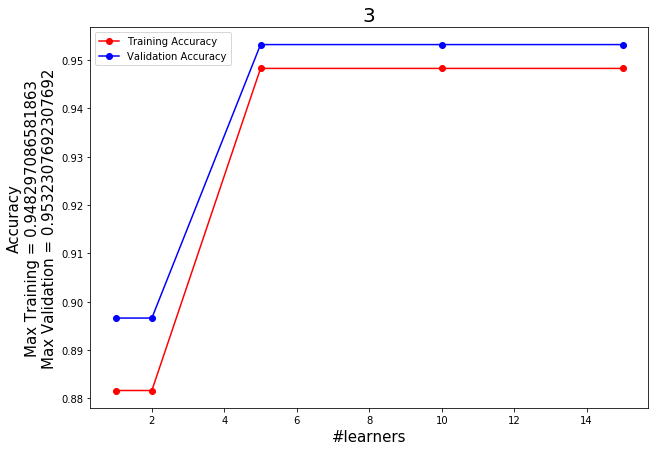

Train_Accuracy
[0.8816167418957734, 0.8816167418957734, 0.948297086581863, 0.948297086581863, 0.948297086581863]
Validation_Accuracy
[0.8966153846153846, 0.8966153846153846, 0.9532307692307692, 0.9532307692307692, 0.9532307692307692]


5

In [60]:
print("------------------------------------3c---------------------------------------")
l = [1,2,5,10,15]
part_3c(l)

In [46]:
print("------------------------------------3e---------------------------------------")
forest3e, alpha3e = ada_boost(6,depth = 2)

------------------------------------3e---------------------------------------


In [46]:
alpha3e

[1.4483432765642212,
 1.2774216842035317,
 1.138113699828624,
 0.6439707167330296,
 0.6911728002983648,
 0.520679919759589]

In [47]:
print("L = 6 | depth = 2")
print("Train accuracy =",boost_accuracy(train_df, alpha3e, forest3e))
print("Val accuracy = ",boost_accuracy(val_df, alpha3e, forest3e))

L = 6 | depth = 2
Train accuracy = 0.9942552318424293
Val accuracy =  0.9956923076923077


In [ ]:
train_df.head()

In [88]:
D = np.array([1/len(train_df)]*len(train_df))
tree1 = decision_tree_algo(train_df,max_depth=6,D=D)
train_df.drop(columns="weights", inplace=True)
prediction1 = test_df.apply(classify_example, args=(tree1,), axis=1)
#prediction1

In [106]:
np.savetxt("./pa3test3.csv", prediction1.astype(int), delimiter=",")

In [70]:
train_df.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,class
0,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [82]:
forest = random_forest(train_df,n=25,m=80,d=6)

In [86]:
forest_accuracy(val_df,forest)

1.0

In [87]:
def forest_prediction(df, forest):
    
    prediction = pd.DataFrame()
    for i in range(len(forest)):
        
        tree = forest[i]
        #Prediction using a tree in the forest
        prediction[i] = (df.apply(classify_example, args=(tree,), axis=1))

    #Calculate number of zeros voted amongst all trees        
    no_columns = prediction.shape[1]
    number_of_zeros = no_columns - prediction.apply(sum, axis=1)
    
    #Check majority vote: Predict 1 if Pr(0) < 0.5 or Number of zeros is less than half the total population
    final_prediction = (number_of_zeros < (no_columns/2)).astype(int)
    #accuracy_bool = final_prediction == df["class"].values
    
    return final_prediction

In [95]:
prediction2 = forest_prediction(test_df,forest)

In [103]:
np.savetxt("./pa3test1.csv", prediction2.astype(int), delimiter=",")

In [101]:
sum(prediction2)

757

In [99]:
sum(prediction1)

757

In [125]:
pred = pd.read_csv("./pa3test.csv", header=None)

In [131]:
pred[0] == prediction1

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
1595    True
1596    True
1597    True
1598    True
1599    True
1600    True
1601    True
1602    True
1603    True
1604    True
1605    True
1606    True
1607    True
1608    True
1609    True
1610    True
1611    True
1612    True
1613    True
1614    True
1615    True
1616    True
1617    True
1618    True
1619    True
1620    True
1621    True
1622    True
1623    True
1624    True
Length: 1625, dtype: bool

In [114]:
len(prediction1)

1625

In [117]:
len(pred)

1625

In [124]:
(pred.iloc[:,0] == prediction1)

1625